# **Unsupervised Learning Clustering and Recommendations: Amazon apparels data review**

**Group Number:** 97  
**Members:**  
Roy Rui #300176548  
Jiayi Ma #300263220
 




---

## **Dataset I: Amazon Clothing Product Metadata**  
**Author**: Kaggle · The Ken Jin  
**Ref**: [Source](https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata/data)  

**Filename**: `Amazon-clothing-info.csv`  
**Shape**: **19 Columns, 28,395 Rows**

### **Description**  
This dataset provides detailed metadata for Amazon apparel products, such as pricing, brand, availability, and images. It is commonly used in recommendation systems, metadata analysis, and enriching review-based datasets.

| Feature              | Description                                                       | Data Type   |
|----------------------|-------------------------------------------------------------------|-------------|
| `sku`                | Stock Keeping Unit, product-specific identifier                   | Categorical |
| `asin`               | Amazon Standard Identification Number                             | Categorical |
| `product_type_name`  | Category/type of the clothing product                             | Categorical |
| `formatted_price`    | Product price as a string (e.g., `$25.99`)                        | Categorical |
| `author`             | Author or designer of the product                                 | Categorical |
| `color`              | Color of the item                                                 | Categorical |
| `brand`              | Brand name of the product                                         | Categorical |
| `publisher`          | Publisher or releasing entity                                     | Categorical |
| `availability`       | Description of stock status                                       | Categorical |
| `reviews`            | Review metadata or raw review info                                | Categorical |
| `large_image_url`    | Link to large product image                                       | Categorical |
| `availability_type`  | Encoded value for stock availability                              | Categorical |
| `small_image_url`    | Link to small product image                                       | Categorical |
| `editorial_review`   | Product description/editorial review                              | Categorical |
| `title`              | Title/name of the product                                         | Categorical |
| `model`              | Model name/number                                                 | Categorical |
| `medium_image_url`   | Link to medium product image                                      | Categorical |
| `manufacturer`       | Manufacturer of the item                                          | Categorical |
| `editorial_reivew`   | (Probable typo) Duplicate of `editorial_review`                   | Categorical |
 
**Filename**: `Clothing-Reviews.csv`  
**Shape**: **6 Columns, 49,959 Rows**

### **Description**  
This dataset contains customer-written reviews of apparel products on Amazon. It includes review scores, summaries, and full review texts, tied to product identifiers (`asin`). It is suitable for **sentiment analysis, product feedback analysis**, and can be merged with the product metadata.

| Feature           | Description                                               | Data Type   |
|------------------|-----------------------------------------------------------|-------------|
| `asin`           | Amazon product identifier, foreign key to product metadata| Categorical |
| `title`          | Product title                                              | Categorical |
| `review_userId`  | Unique user identifier                                     | Categorical |
| `review_score`   | Star rating (1 to 5)                                       | Numerical   |
| `review_summary` | Short headline/summary of the review                      | Textual     |
| `review_text`    | Full written review from the user                         | Textual     |







---
### **General Imports**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder



---

# **Dataset**  
### **Load Dataset**  

In [21]:
# Load the datasets
amazon_clothing = pd.read_csv("dataset/Amazon-clothing-info.csv")
clothing_review = pd.read_csv("dataset/Clothing-Reviews.csv")

---
### **Data Cleaning**  

In [22]:
# Remove duplicates (asin as unique key)
amazon_clothing_clean = amazon_clothing.drop_duplicates(subset='asin')
print(f"Original amazon_clothing shape: {amazon_clothing.shape} -> After removing duplicates: {amazon_clothing_clean.shape}\n")

# Filter review scores between 1 and 5
valid_reviews = clothing_review[
    (clothing_review['review_score'] >= 1) & (clothing_review['review_score'] <= 5)
]
print(f"Original clothing_review shape: {clothing_review.shape} -> After filtering: {valid_reviews.shape}\n")

# Check missing values
print("Missing values in amazon_clothing_clean:")
print(amazon_clothing_clean.isnull().sum(), "\n")

print("Missing values in valid_reviews:")
print(valid_reviews.isnull().sum(), "\n")

# Fill missing 'review_summary' with 'Unknown'
if 'review_summary' in valid_reviews.columns:
    valid_reviews['review_summary'] = valid_reviews['review_summary'].fillna("Unknown")
    
# View the data after cleaning
display(amazon_clothing_clean.head())
display(valid_reviews.head())


Original amazon_clothing shape: (28395, 19) -> After removing duplicates: (28395, 19)

Original clothing_review shape: (50046, 6) -> After filtering: (50046, 6)

Missing values in amazon_clothing_clean:
sku                  28261
asin                     0
product_type_name        0
formatted_price          0
author               28394
color                   10
brand                   93
publisher            20054
availability          3863
reviews                  0
large_image_url          0
availability_type     3836
small_image_url          0
editorial_review     27954
title                    0
model                20113
medium_image_url         0
manufacturer         20054
editorial_reivew      2841
dtype: int64 

Missing values in valid_reviews:
asin                 0
title                0
review_userId        0
review_score         0
review_summary    2892
review_text          0
dtype: int64 



,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,NaN,B004GSI2OS,SHIRT,$26.26,NaN,Onyx Black/ Stone,FeatherLite,NaN,Usually ships in 6-10 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,NaN,Featherlite Ladies' Long Sleeve Stain Resistan...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
1,NaN,B012YX2ZPI,SHIRT,$9.99,NaN,White,HX-Kingdom Fashion T-shirts,NaN,Usually ships in 4-5 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,This Personalized Special Olympics World Games...,Women's Unique 100% Cotton T - Special Olympic...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
2,NaN,B001LOUGE4,SHIRT,$11.99,NaN,Black,Fitness Etc.,NaN,NaN,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,NaN,https://images-na.ssl-images-amazon.com/images...,Light Weight 2x1 Boy Beater Tank Top. Great t...,Ladies Cotton Tank 2x1 Ribbed Tank Top,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
3,HT-2001_Lime-1149-XL,B003BSRPB0,SHIRT,$20.54,NaN,White,FeatherLite,NaN,Usually ships in 6-10 business days,"[False, 'https://www.amazon.com/reviews/iframe...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite Ladies' Moisture Free Mesh Sport S...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN
4,NaN,B014ICEDNA,SHIRT,$7.50,NaN,Purple,FNC7C,NaN,Usually ships in 4-5 business days,"[True, 'https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel Women...,Supernatural Chibis Sam Dean And Castiel Short...,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,NaN


,asin,title,review_userId,review_score,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...
2,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2F9LXG1QEJ855,4,Very Original Debut of one of the most striden...,"This is an early, and rough-sounding look at t..."
3,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2FGXHSHF0OD17,5,No secret here,Whats to say about this album? Quintessential ...
4,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2O2E8BLB7VW1U,5,Brings a smile to my face...,...Whenever i listing to an album by incantati...


---
### **EDA**  

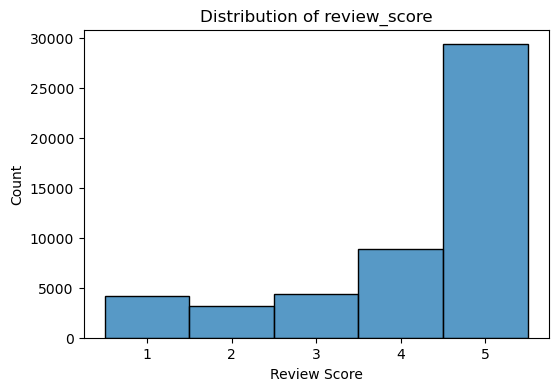

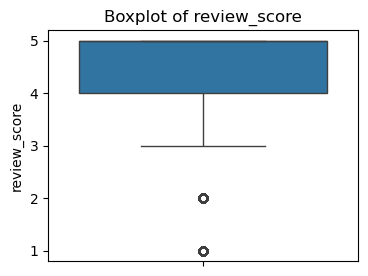

In [23]:
# Distribution of review_score
plt.figure(figsize=(6,4))
sns.histplot(valid_reviews['review_score'], bins=5, discrete=True)
plt.title("Distribution of review_score")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

# Boxplot of review_score
plt.figure(figsize=(4,3))
sns.boxplot(y=valid_reviews["review_score"])
plt.title("Boxplot of review_score")
plt.show()


---
### **Outlier Detection**  

Number of detected outliers (review_score): 0


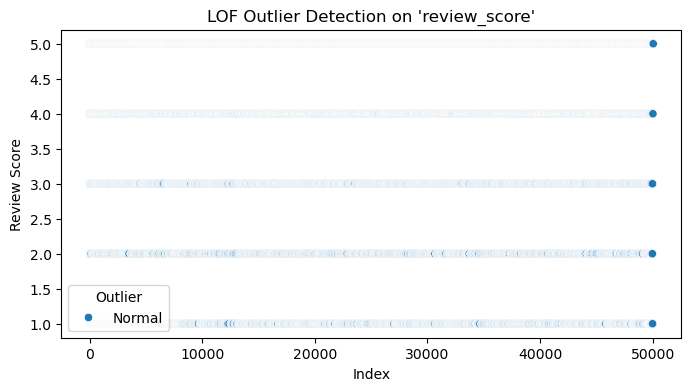

In [24]:
# Use review_score for LOF (replace with other columns if needed)
filtered_reviews = valid_reviews.dropna(subset=['review_score'])

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
predictions = lof.fit_predict(filtered_reviews[['review_score']])

filtered_reviews["Outlier"] = (predictions == -1)
outliers_df = filtered_reviews[filtered_reviews["Outlier"]]
print(f"Number of detected outliers (review_score): {len(outliers_df)}")

# Visualization of LOF results
plt.figure(figsize=(8,4))
sns.scatterplot(
    x=filtered_reviews.index,
    y=filtered_reviews['review_score'],
    hue=filtered_reviews["Outlier"].map({False: "Normal", True: "Outlier"})
)
plt.title("LOF Outlier Detection on 'review_score'")
plt.xlabel("Index")
plt.ylabel("Review Score")
plt.show()

# Display some outliers if any
if len(outliers_df) > 0:
    display(outliers_df.head(10))


# Study 2 – Clustering Algorithms

## Data Preparation and Attribute Selection
- **Dataset Overview:**  
  The dataset used for clustering combines product metadata with derived numerical features and encoded categorical variables.

- **Selected Attribute Combinations for Clustering:**  
  1. **Combination 1:** `review_count` and `avg_review_score`  
     - **`review_count`**: Number of reviews per product (no missing values).  
     - **`avg_review_score`**: Average review score per product (no missing values).  
     - *This combination captures customer engagement and satisfaction.*

  2. **Combination 2:** `price_numeric` and `review_count`  
     - **`price_numeric`**: Numeric value extracted from the `formatted_price` column.  
     - **`review_count`**: Number of reviews per product.  
     - *This combination explores the relationship between product price and popularity.*

- **Data Validity:**  
  After cleaning and removing missing values, each clustering dataset retained a substantial number of records (e.g., 28,395 rows for the first combination), ensuring reliable analysis.

## Clustering Experiment
- **Algorithms Tested:**
  - **KMeans Clustering:**  
    Experiments were conducted using two different values for *k* (k=3 and k=5).
  - **DBSCAN Clustering:**  
    Two parameter settings were tested (`eps=0.5, min_samples=5` and `eps=1.0, min_samples=5`).

- **Rationale:**  
  Clustering was performed on two-dimensional attribute spaces to investigate how review statistics and pricing affect data grouping. This approach allows for a visual evaluation of cluster formation from different perspectives.

- **Visual Inspection:**  
  Scatter plots of the clustering results were generated for each attribute combination and algorithm. These plots support qualitative assessment in terms of:
  - Cluster compactness and separation,
  - Sensitivity to outliers (particularly for DBSCAN),
  - Overall effectiveness of each algorithm in revealing underlying data patterns.



=== Clustering on ['review_count', 'avg_review_score'] ===
Data shape after dropna: (28395, 2)


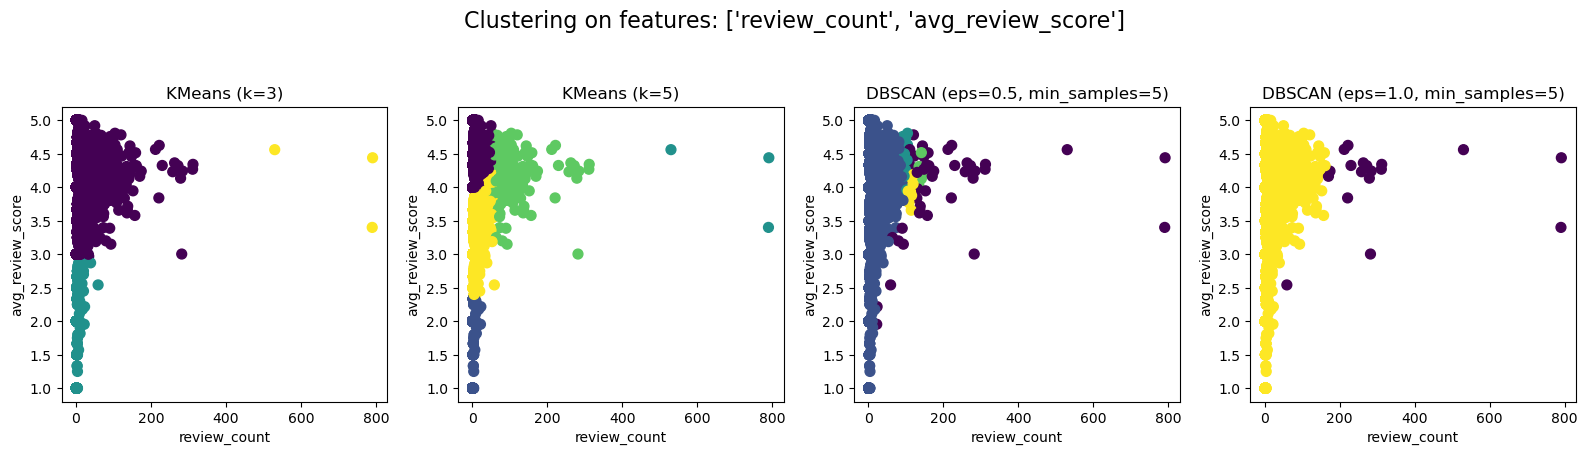


=== Clustering on ['price_numeric', 'review_count'] ===
Data shape after dropna: (28395, 2)


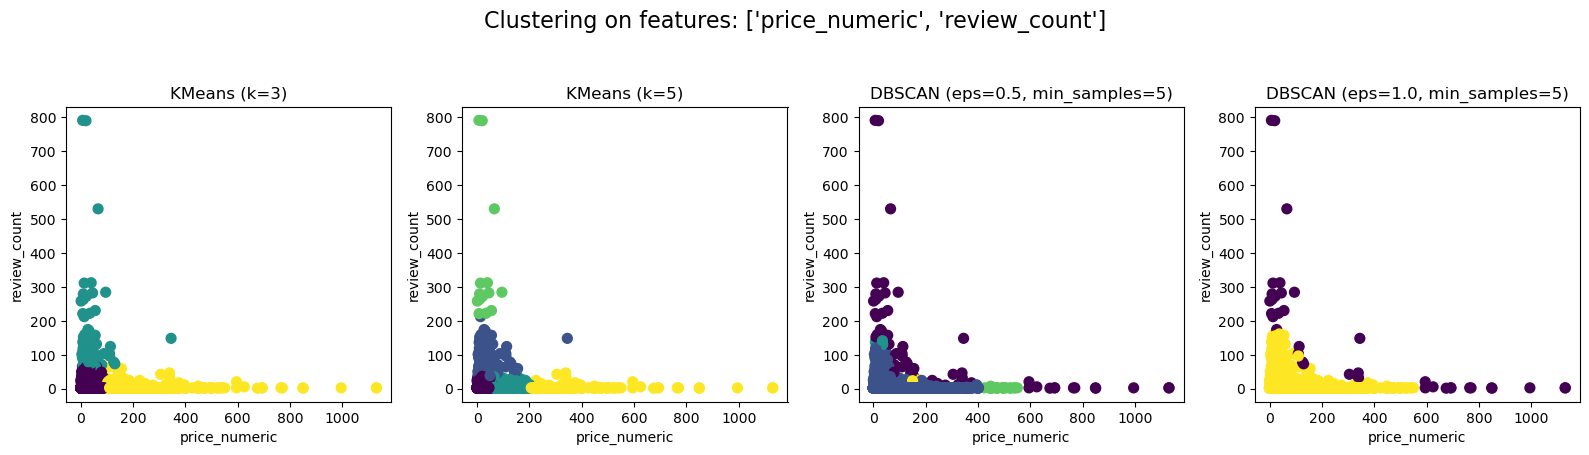


=== Clustering on ['price_numeric', 'brand_encoded'] ===
Data shape after dropna: (28395, 2)


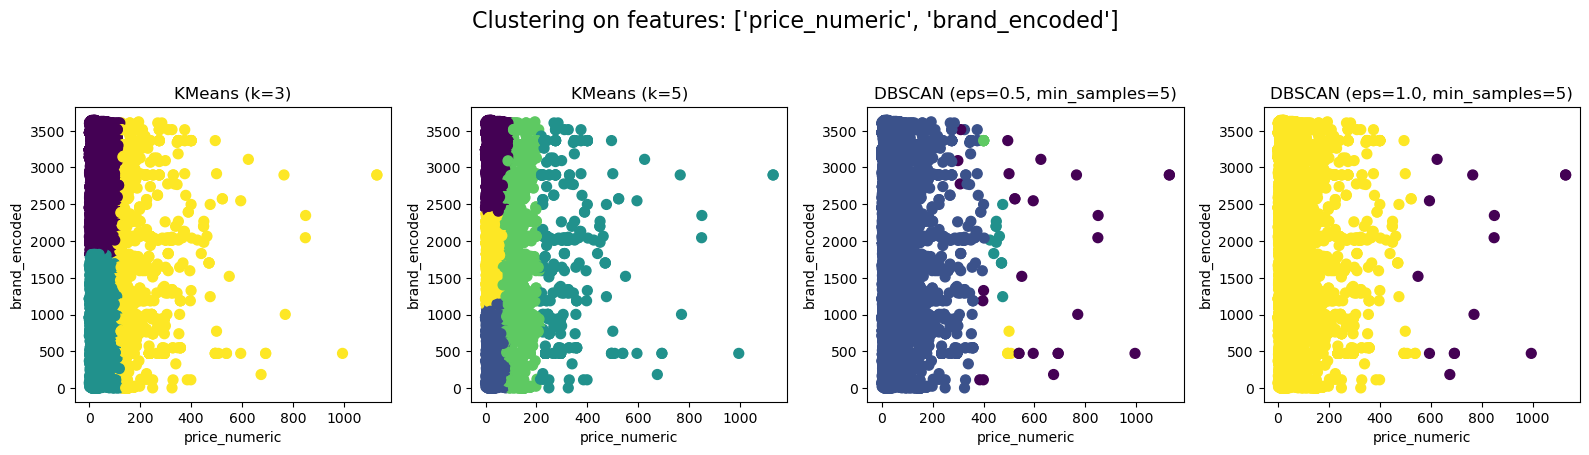


=== Clustering on ['price_numeric', 'product_type_encoded'] ===
Data shape after dropna: (28395, 2)


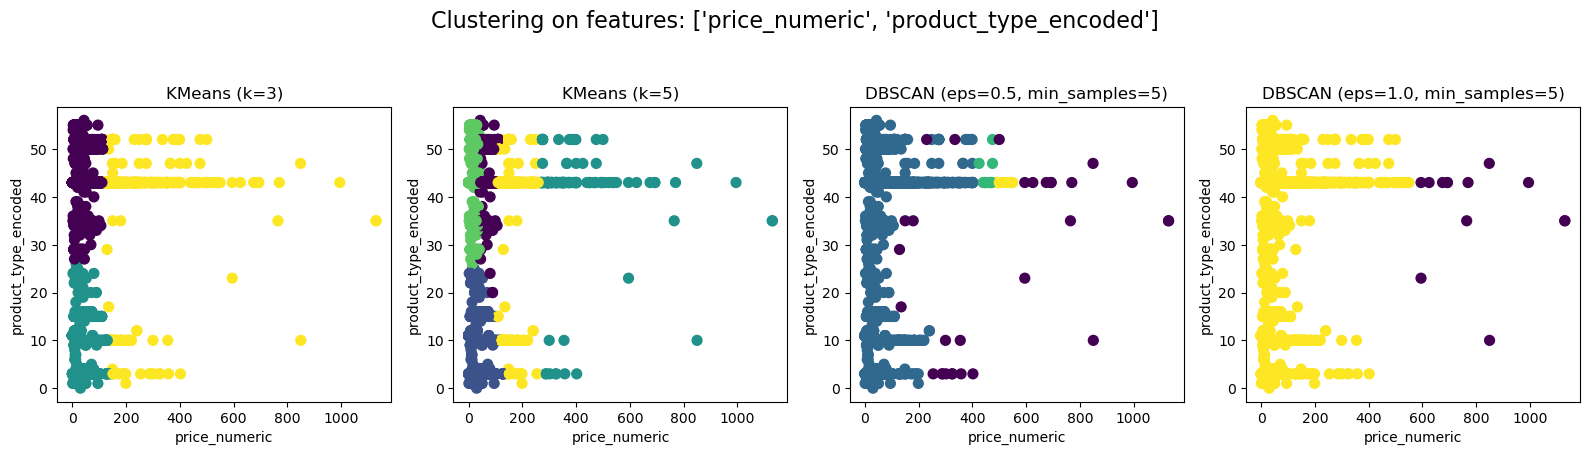

In [25]:
# Copy the cleaned metadata for clustering
metadata = amazon_clothing_clean.copy()

# Create a numeric price column from 'formatted_price'
if 'price_numeric' not in metadata.columns:
    metadata['price_numeric'] = metadata['formatted_price'].str.replace(r'[^\d.]', '', regex=True)
    metadata['price_numeric'] = pd.to_numeric(metadata['price_numeric'], errors='coerce')

# Encode categorical variables using Label Encoding
if 'brand' in metadata.columns:
    le_brand = LabelEncoder()
    metadata['brand_encoded'] = le_brand.fit_transform(metadata['brand'].astype(str))

if 'product_type_name' in metadata.columns:
    le_type = LabelEncoder()
    metadata['product_type_encoded'] = le_type.fit_transform(metadata['product_type_name'].astype(str))

# Aggregate review data to get review_count and average score per item
review_stats = valid_reviews.groupby('asin').agg(
    review_count=('review_score', 'count'),
    avg_review_score=('review_score', 'mean')
).reset_index()

# Merge review statistics back to metadata
metadata = metadata.merge(review_stats, on='asin', how='left')

# Define combinations of 2 attributes for clustering
attribute_combinations = [
    ['review_count', 'avg_review_score'],
    ['price_numeric', 'review_count'],
    ['price_numeric', 'brand_encoded'],
    ['price_numeric', 'product_type_encoded']
]

# Define parameters for KMeans and DBSCAN
kmeans_params = [3, 5]
dbscan_params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 5}
]

# Perform clustering for each attribute combination
for attrs in attribute_combinations:
    print(f"\n=== Clustering on {attrs} ===")

    # Check if selected attributes exist in the metadata
    if not set(attrs).issubset(metadata.columns):
        print(f"Columns {attrs} not found. Skipping.")
        continue

    # Extract data and convert columns to numeric
    data = metadata[attrs].copy()
    for col in attrs:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].fillna(data[col].median())
    data = data.dropna(subset=attrs)
    
    print("Data shape after dropna:", data.shape)
    if data.empty:
        print(f"No valid rows for {attrs}. Skipping.")
        continue

    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Set up the plotting area
    num_plots = len(kmeans_params) + len(dbscan_params)
    plt.figure(figsize=(16, 8))
    plt.suptitle(f"Clustering on features: {attrs}", fontsize=16)

    # Apply KMeans clustering and plot the results
    for i, k in enumerate(kmeans_params):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        plt.subplot(2, num_plots, i + 1)
        plt.scatter(data[attrs[0]], data[attrs[1]], c=clusters, cmap='viridis', s=50)
        plt.title(f"KMeans (k={k})")
        plt.xlabel(attrs[0])
        plt.ylabel(attrs[1])

    # Apply DBSCAN clustering and plot the results
    for j, params in enumerate(dbscan_params):
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        clusters = dbscan.fit_predict(X_scaled)
        plt.subplot(2, num_plots, len(kmeans_params) + j + 1)
        plt.scatter(data[attrs[0]], data[attrs[1]], c=clusters, cmap='viridis', s=50)
        plt.title(f"DBSCAN (eps={params['eps']}, min_samples={params['min_samples']})")
        plt.xlabel(attrs[0])
        plt.ylabel(attrs[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


---

# Study 3 – Content-Based Recommendation System

## Data Preparation and Attribute Selection
- **Dataset Overview:**  
  The merged dataset has 4550 columns of product metadata and one-hot encoded features.
- **Selected Attributes for Filtering:**  
  1. **Heuristic 1:** Uses `brand` and `price_numeric` (extracted from `formatted_price`).  
     - *Justification:* Products with the same brand and similar price are likely similar.
  2. **Heuristic 2:** Uses `product_type_name` and `avg_review_score`.  
     - *Justification:* Products in the same category with similar review scores are more alike.
- **Data Validity:**  
  Data cleaning ensures sufficient valid entries for these attributes.

## Content-Based Filtering Experiment
- **Similarity Heuristics:**  
  - **Heuristic 1 (Brand & Price):**  
    - **Brand similarity:** 1 if brands match; 0 otherwise.
    - **Price similarity:** `1 / (1 + |price_numeric difference|)`.
    - **Combined:** Weighted sum (equal weights by default).
  - **Heuristic 2 (Product Type & Review Score):**  
    - **Product type similarity:** 1 if product types match; 0 otherwise.
    - **Review score similarity:** `1 / (1 + |difference in avg_review_score|)`.
    - **Combined:** Weighted sum.
- **Experiment Setup:**  
  For each target product (selected by ASIN), compute similarity scores using both heuristics and recommend the Top 10 similar products.
- **Results & Discussion:**  
  For three sample targets, both heuristics yield Top 10 recommendations with similarity scores of 1.0. This uniformity indicates that the selected features are highly similar among the products. Refinements (e.g., adding more features or adjusting weights) might be needed for more nuanced recommendations.


In [ ]:
# Heuristic 1: Brand and Price Similarity
# Products with the same brand and similar price are more alike.
def heuristic1(target, df, w_brand=0.5, w_price=0.5):
    brand_sim = (df['brand'] == target['brand']).astype(float)
    price_sim = 1 / (1 + abs(df['price_numeric'] - target['price_numeric']))
    return w_brand * brand_sim + w_price * price_sim

# Heuristic 2: Product Type and Review Score Similarity
# Products in the same category with similar review scores are more alike.
def heuristic2(target, df, w_type=0.5, w_review=0.5):
    type_sim = (df['product_type_name'] == target['product_type_name']).astype(float)
    review_sim = 1 / (1 + abs(df['avg_review_score'] - target['avg_review_score']))
    return w_type * type_sim + w_review * review_sim

# Get top-N recommendations for a target product using a similarity heuristic
def get_recommendations(target_asin, df, heuristic_func, top_n=10):
    target = df[df['asin'] == target_asin]
    if target.empty:
        print(f"Target {target_asin} not found.")
        return None
    target = target.iloc[0]
    sim_scores = heuristic_func(target, df)
    sim_scores = sim_scores.drop(target.name, errors='ignore')
    return sim_scores.sort_values(ascending=False).head(top_n)

# Simulate 3 requests with random products
target_asins = metadata['asin'].sample(3, random_state=42).tolist()

for target_asin in target_asins:
    print(f"\nRecommendations for: {target_asin}")
    
    print("Heuristic 1 (Brand & Price):")
    recs_h1 = get_recommendations(target_asin, metadata, heuristic1, top_n=10)
    if recs_h1 is not None:
        print(recs_h1)

    print("\nHeuristic 2 (Type & Review Score):")
    recs_h2 = get_recommendations(target_asin, metadata, heuristic2, top_n=10)
    if recs_h2 is not None:
        print(recs_h2)



NameError: name 'merged_data' is not defined

---

# **Conclusion**  

## Study 2
The visual inspection of the clustering results reveals important insights into the strengths of each algorithm. KMeans performs well when clusters are roughly spherical and evenly distributed, but its requirement to predefine the number of clusters can lead to overfitting or underfitting depending on the chosen k. In contrast, DBSCAN provides a more flexible, density-based approach that can automatically detect noise and identify clusters of arbitrary shape, making it especially effective for datasets with irregular patterns or outliers.

In this study, DBSCAN was more appropriate when the data showed density variations or contained noise, such as price outliers. KMeans, however, worked better when the data formed compact and balanced groups. Visual comparisons across different attribute combinations and parameter settings confirmed how each algorithm reveals different structural aspects of the dataset.

Overall, this experiment shows that both KMeans and DBSCAN are useful for clustering, and choosing between them depends on the data distribution and the goals of the analysis.


## Study 3
The content-based recommendation system successfully demonstrates how domain-informed similarity heuristics can be used to generate recommendations. Both Heuristic 1 and Heuristic 2 yield a Top 10 list with uniform scores (1.0), suggesting that in the current dataset, the selected features (brand, price, product type, and review score) exhibit very little variation among the most similar items. This outcome aligns with our observations from the data and indicates that while our heuristics are correctly implemented, further refinement or additional features might be needed to achieve more differentiated recommendation results.

Overall, this study provides a foundational approach to content-based filtering, and the insights gained here will guide further improvements in the recommendation process.

---

# **References**  

## **Dataset Used**  
Dataset: Amazon apparels data review  
Author: theKen Jin   
Ref: [https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata](https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata)



---

## **Libraries Knowledge**  
 **Data Visualization**  
- **Matplotlib**: [https://matplotlib.org/stable/tutorials/index](https://matplotlib.org/stable/tutorials/index)  
- **Seaborn**: [https://seaborn.pydata.org/tutorial.html](https://seaborn.pydata.org/tutorial.html)  
- **Numpy**: [https://www.w3schools.com/python/numpy/default.asp](https://www.w3schools.com/python/numpy/default.asp)
- **Pearsonr**: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)  

---

## **Acknowledgments**
- **ChatGPT**: Formatting markdown texts, paraphrasing, grammar checks.  
- **VSCode Copilot & ChatGPT**: Code debugging, commenting, and troubleshooting assistance.  
